# Visualize Toulouse water system including water fountains

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
import shapely
import pandas as pd
import geopandas as gpd
import contextily as cx

#### <br> Extracting open data on water fountains in Toulouse 

#### *This geojson file can be downloaded on the French open data portal here: https://www.data.gouv.fr/fr/datasets/618c95a4a917d615b14a1318/*

In [3]:
file_path = "fontaines-a-boire.geojson"

In [4]:
gdf = gpd.read_file(file_path)

In [5]:
gdf = gdf.to_crs(3857)  # EPSG:4326 to EPSG:3857

In [6]:
gdf.head()

,etat,ref_service,identifiant,localisation,verif2014,service_source,type,id,geometry
0,HS,CN04,CN04,LAKANAL RUE - Face n° 12,ok,MQC,BAYARD,7,MULTIPOINT (160388.933 5404281.561)
1,en service,CN09,CN09,PLACE DU SALIN - Face N° 18 PHARAON (proche St...,ok,MQC,BAYARD,8,MULTIPOINT (160743.204 5402945.889)
2,non renseigné,SE37,SE37,ST EXUPERY AV - N°200bis Groupe scolaire Courrège,ok,MQC,BAYARD,11,MULTIPOINT (164290.536 5400924.938)
3,en service,N30,N30,MARCHE AUX COCHONS PLACE - BOURBAKI,ok,MQC,BAYARD,13,MULTIPOINT (159696.492 5406877.986)
4,fermé,21,21,JARDIN BOIS DAURADE (rue du Général Giraud),ok,Espace vert,BAYARD,32,MULTIPOINT (162728.886 5410225.223)


In [7]:
etats = gdf.etat.unique().tolist()
print(etats)  # status of each fountain

['HS', 'en service', 'non renseigné', 'fermé']


#### <br> Then we get data of the water system above Toulouse

#### *The HYDROGRAPHIE folder (Haute-Garonne) is an open data (IGN BD TOPO). You can download it on the French open data portal here: https://www.data.gouv.fr/fr/reuses/le-reseau-hydro-sur-le-geoportail-1/*

In [8]:
def filter_by_overlay_and_bounding_box(from_shape, filter, buffer_dist=0):
    bound = shapely.geometry.box(*filter.total_bounds).buffer(buffer_dist)
    bound = gpd.GeoDataFrame(gpd.GeoSeries(bound), columns=["geometry"])
    bound = bound.set_crs(from_shape.crs)
    return gpd.overlay(from_shape, bound, how="intersection")

In [9]:
hydrography_folder = "HYDROGRAPHIE"
hydro_files = [
    "COURS_D_EAU",
    "PLAN_D_EAU",
    "SURFACE_HYDROGRAPHIQUE",
    "TRONCON_HYDROGRAPHIQUE",
]
df_list = []
for f in glob(hydrography_folder + "/*.shp"):
    if Path(f).stem in hydro_files:
        df = gpd.read_file(f)
        df = df.to_crs(3857)  # EPSG:2154 to EPSG:3857
        df_list.append(filter_by_overlay_and_bounding_box(df, gdf))

In [10]:
hdf = gpd.GeoDataFrame(pd.concat(df_list, ignore_index=True), crs=df_list[0].crs)

#### <br> Plot water system & fountains on background map

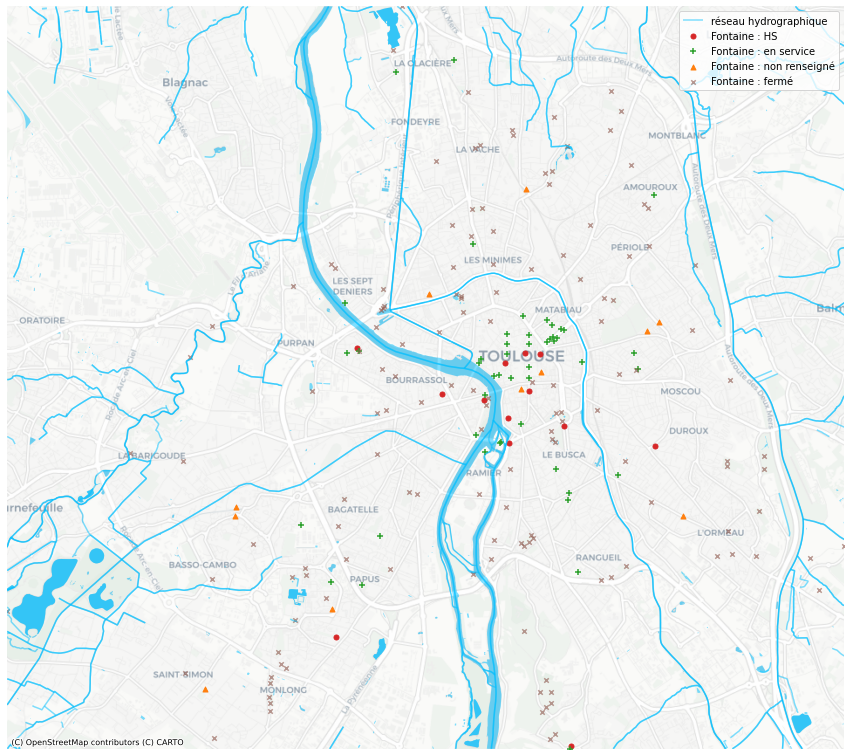

In [11]:
colors = ["tab:red", "tab:green", "tab:orange", "tab:brown"]
markers = ["o", "+", "^", "x"]
markersizes = [25, 32, 25, 20]
alphas = [1.0, 1.0, 1.0, 0.6]  # [0.7, 1.0, 0.8, 0.8]
fig, ax = plt.subplots(figsize=(15, 15))

hdf.plot(ax=ax, color="deepskyblue", label="réseau hydrographique", alpha=0.5)

for (etat, color, marker, ms, alpha) in zip(
    etats, colors, markers, markersizes, alphas
):
    gdf.query("etat==@etat").plot(
        ax=ax,
        alpha=alpha,
        color=color,
        marker=marker,
        markersize=ms,
        label="Fontaine : " + etat,
    )
ax.set_axis_off()
ax.margins(0)
ax.legend()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=13, alpha=1.0)
plt.savefig("toulouse_water.png", dpi=100, bbox_inches="tight")